# Modern Portfolio Theory

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion_.

Based on [Modern Porfolio Theory: the optimal portfolio](https://github.com/r-poli/ModernPorfolioTheory/)

Paper: https://towardsdatascience.com/python-for-finance-an-implementation-of-the-modern-portfolio-theory-39cdbaeefbd4

Changes were to be made as the API in the original source is no longer free. In the same time the [Finnhub API]( https://finnhub.io/docs/api) does not provide free historical data for a period longer than one year.

The original code was modified to use arbitrary data in format date vs price.

## Introduction

* Modern portfolio theory (MPT) is a theory on how risk-averse investors can construct portfolios to maximize expected return based on a given level of market risk.
* MPT can also be used to construct a portfolio that minimizes risk for a given level of expected return.
* Modern portfolio theory is very useful for investors trying to construct efficient portfolios using ETFs.
* Investors who are more concerned with downside risk than variance might prefer post-modern portfolio theory (PMPT) to MPT.

Links
* https://www.investopedia.com/terms/m/modernportfoliotheory.asp
* https://en.wikipedia.org/wiki/Modern_portfolio_theory

## Code

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Define company symbols
The data here is for real companies with names changed. Here is the place to enter your ticks with related company names.

In [2]:
ticks = ["CMP1", "CMP2", "CMP3", "CMP4", "CMP5", "CMP6"]
line_name = ["Company 1", "Company 2", "Company 3", "Company 4", "Company 5","Company 6"]

### Define simulation parameters

The number of portolios to be simulated. _Recommended number > 5000_

In [3]:
number_portfolios = 40000

The range of dates to perform the backtesting in. _Recommended range > 3 years_

In [4]:
start_date = '16/01/2016'
end_date = '16/01/2021'

### Download historical data

The input data time stamps are in format `YYYY-MM-DD` (year-month-day) under label `time`. For the simulation it has to be converted to Unix timestamp as used in the original code. The conversion result will be under label `t`. Consider adjusting this section according to use different format or APIs.

In the original paper the `c` key data is used which stahds for `List of close prices for returned candles`. During further processing it was renamed to the corresponding tick.

In [5]:
def add_timestamp(candles_data):
    candles_data['time']= pd.to_datetime(candles_data['time'], format="%Y-%m-%d")
    return candles_data

Prepare common container for historical data.

In [6]:
data_dict = dict()

In [7]:
data_dict['CMP1'] = add_timestamp(pd.read_csv('data_company1.csv'))

In [8]:
data_dict['CMP2'] = add_timestamp(pd.read_csv('data_company2.csv'))

In [9]:
data_dict['CMP3'] = add_timestamp(pd.read_csv('data_company3.csv'))

In [10]:
data_dict['CMP4'] = add_timestamp(pd.read_csv('data_company4.csv'))

In [11]:
data_dict['CMP5'] = add_timestamp(pd.read_csv('data_company5.csv'))

In [12]:
data_dict['CMP6'] = add_timestamp(pd.read_csv('data_company6.csv'))

### Convert data to reader-friendly format

In [13]:
data_to_concat = []

for key in data_dict:
    data_to_concat.append(data_dict[key])

price_data = pd.concat(data_to_concat, axis=1, join='inner')

# The duplicated values and timestamp column are removed
price_data = price_data.loc[:,~price_data.columns.duplicated()].set_index('time')

In [14]:
# Calculate logarithmic return value in time
log_ret = np.log(price_data/price_data.shift(1))

# Covariance of periodic returns
cov_mat = log_ret.cov() * 252

### Initialize elements

In [15]:
# Weights of portfolio elements
all_wts = np.zeros((number_portfolios, len(price_data.columns)))

# Portfolio returns
port_returns = np.zeros((number_portfolios))

# Portfolio Risk
port_risk = np.ones((number_portfolios))

# Sharpe Ratio (performance of an investment compared to a risk-free asset after adjusting for its risk)
sharpe_ratio = np.zeros((number_portfolios))

### Simulate Portfolios

In [16]:
# Set the random seed for reproducible results
np.random.seed(42)

In [17]:
def generate_weights(weights_len):
    weights_result = []
    remain_weight = weights_len
    
    for _ in range(weights_len):
        if remain_weight <= 0:
            weights_result.append(0)
            continue
        current_weight = np.random.uniform(remain_weight)
        weights_result.append(current_weight)
        remain_weight = remain_weight - current_weight
        
    np.random.shuffle(weights_result)
    return weights_result

In [18]:
for i in range(number_portfolios):

    # Portfolio weights
#     wts = np.random.uniform(size=len(price_data.columns))
    wts = generate_weights(len(price_data.columns))
    wts = wts / np.sum(wts)
    all_wts[i, :] = wts

    # Portfolio Return
    port_ret = np.sum(log_ret.mean() * wts)
    port_ret = (port_ret + 1) ** 252 - 1
    port_returns[i] = port_ret

    # Portfolio Risk
    port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
    port_risk[i] = port_sd

    # Portfolio Sharpe Ratio, assuming 0% Risk Free Rate
    sr = port_ret / port_sd
    sharpe_ratio[i] = sr

    # Save portfolios of interest
    # Maximal Sharpe Ratio
    if sr >= max(sharpe_ratio[0:-1]):
        max_sr_ret = port_ret
        max_sr_risk = port_sd
        max_sr_w = wts
        max_sr = sr

    # Maximal return
    if port_ret >= max(port_returns[0:-1]):
        max_ret_ret = port_ret
        max_ret_risk = port_sd
        max_ret_w = wts

    # Minimal variance
    if port_sd <= min(port_risk[0:-1]):
        min_var_ret = port_ret
        min_var_risk = port_sd
        min_var_w = wts

## Results

### Portfolios Risk vs Return

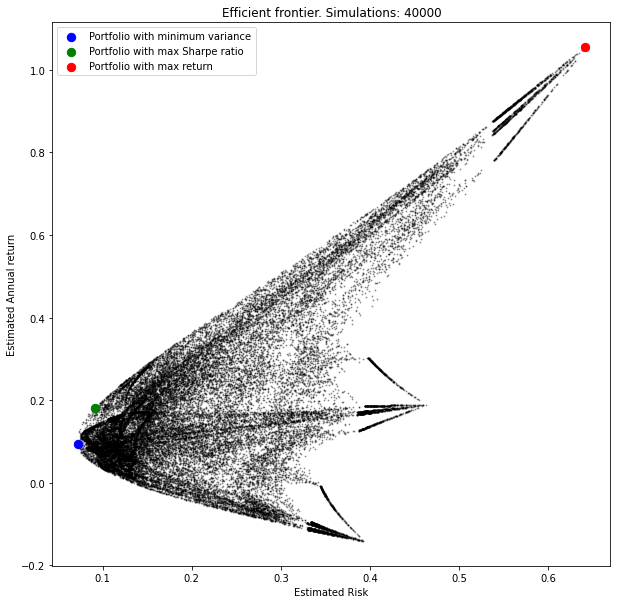

In [19]:
plt.figure(figsize=(10,10))

plt.title("Efficient frontier. Simulations: " + str(number_portfolios))

plt.scatter(port_risk, port_returns, color='black', alpha=0.3, s=1)
plt.scatter(min_var_risk, min_var_ret, color='b', label='Portfolio with minimum variance', s=70)
plt.scatter(max_sr_risk, max_sr_ret, color='g', label='Portfolio with max Sharpe ratio', s=70)
plt.scatter(max_ret_risk, max_ret_ret, color='r', label='Portfolio with max return', s=70)

plt.legend()

plt.ylabel('Estimated Annual return')
plt.xlabel('Estimated Risk')

plt.show()

In [20]:
def print_portfolio(porfolio_return, portfolio_risk, porfolio_weights, sharpe_ratio = None):
    print(f"Return: {porfolio_return*100:.2f} %")
    print(f"Risk: {portfolio_risk*100:.2f} %")
    
    if sharpe_ratio is not None:
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    
    company_ratios = {}
    for i in range(len(ticks)):
        company_ratios[porfolio_weights[i]] = i
    
    sorted_ratios = sorted(company_ratios, reverse=True)
    
    for ratio in sorted_ratios:
        tick_index = company_ratios[ratio]
        print(f"{line_name[tick_index]} ({ticks[tick_index]}) {porfolio_weights[tick_index]*100:.2f} %")

### Minimal Variance Portfolio

In [21]:
print_portfolio(min_var_ret, min_var_risk, min_var_w)

Return: 9.45 %
Risk: 7.23 %
Company 2 (CMP2) 40.38 %
Company 5 (CMP5) 34.78 %
Company 3 (CMP3) 20.41 %
Company 4 (CMP4) 4.43 %
Company 6 (CMP6) 0.00 %


### Maximal Sharp Ratio Portfolio

In [22]:
print_portfolio(max_sr_ret, max_sr_risk, max_sr_w, max_sr)

Return: 18.22 %
Risk: 9.14 %
Sharpe Ratio: 1.99
Company 5 (CMP5) 44.12 %
Company 2 (CMP2) 29.28 %
Company 3 (CMP3) 17.45 %
Company 1 (CMP1) 9.14 %
Company 6 (CMP6) 0.00 %


### Maximal Return Portfolio

In [23]:
print_portfolio(max_ret_ret, max_ret_risk, max_ret_w)

Return: 105.56 %
Risk: 64.12 %
Company 1 (CMP1) 99.55 %
Company 6 (CMP6) 0.45 %
Company 5 (CMP5) 0.00 %


### Simulated Stock Prices over Time

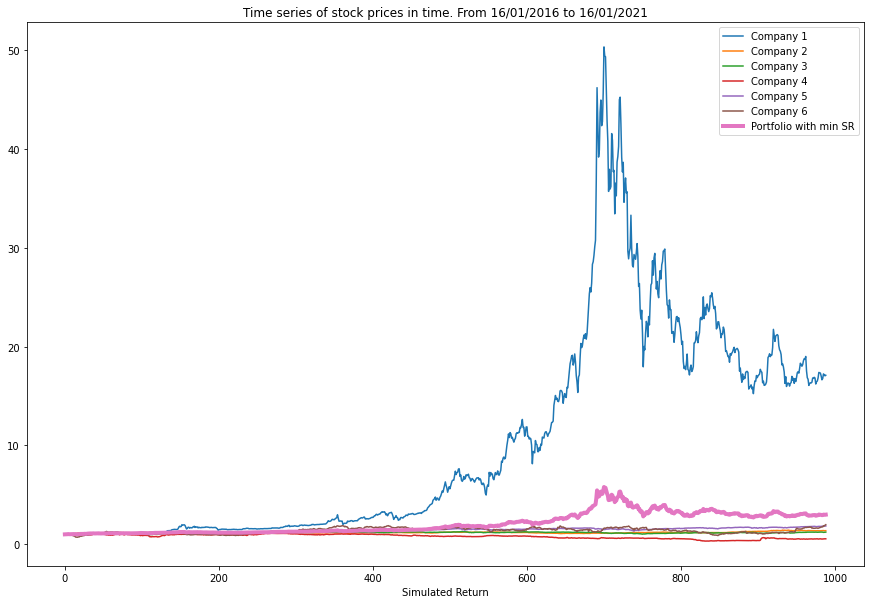

In [24]:
plt.figure(figsize=(15,10))

plt.title('Time series of stock prices in time. From ' + start_date + ' to ' + end_date)

i = 0
val_max_shr = 0

for tick in ticks:
    plt.plot(range(0, len(price_data[tick])), list(price_data[tick]/(price_data[tick][0])),
                label=line_name[i]) 

    val_max_shr += price_data[tick] / (price_data[tick][0]) * max_sr_w[i]

    i += 1

plt.plot(range(0, len(price_data[ticks[0]])), list(val_max_shr), label="Portfolio with min SR", linewidth=4 )

plt.legend()

plt.xlabel('Trading day')
plt.xlabel('Simulated Return')

plt.show()